In [1]:
# Import necessary libraries
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest  # Import Isolation Forest

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the synthetic dataset from kaggle
data = pd.read_csv('/kaggle/input/synthetic-network-traffic/synthetic_network_traffic.csv')


In [3]:
# Feature Engineering: Generate additional features (you can customize this)
data['TotalBytes'] = data['BytesSent'] + data['BytesReceived']
data['TotalPackets'] = data['PacketsSent'] + data['PacketsReceived']


In [4]:
# Oversample the 'Anomaly' class to balance the class distribution
anomaly_data = data[data['IsAnomaly'] == 1]
oversampled_data = pd.concat([data, anomaly_data], axis=0)


In [5]:
# Split the dataset into features and labels
X = oversampled_data.drop(columns=['IsAnomaly'])  # Features
y = oversampled_data['IsAnomaly']  # Labels

In [6]:
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [7]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
# Create and fit the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

In [9]:
# Predict anomalies using the Isolation Forest
y_pred_iforest = isolation_forest.predict(X_test)
y_pred_iforest = (y_pred_iforest == -1)  # Convert -1 (anomaly) to 1, 1 (normal) to 0


In [10]:
# Create the deep learning model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification, use 'sigmoid' for anomaly detection
])

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Apply threshold (adjust as needed)

Epoch 1/5
21985/21985 [==============================] - 95s 4ms/step - loss: 0.0582 - accuracy: 0.9897 - val_loss: 0.0569 - val_accuracy: 0.9900
Epoch 2/5
21985/21985 [==============================] - 88s 4ms/step - loss: 0.0565 - accuracy: 0.9900 - val_loss: 0.0562 - val_accuracy: 0.9900
Epoch 3/5
21985/21985 [==============================] - 87s 4ms/step - loss: 0.0563 - accuracy: 0.9900 - val_loss: 0.0563 - val_accuracy: 0.9900
Epoch 4/5
21985/21985 [==============================] - 89s 4ms/step - loss: 0.0563 - accuracy: 0.9900 - val_loss: 0.0563 - val_accuracy: 0.9900
Epoch 5/5
4711/4711 [==============================] - 7s 2ms/step


In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly'], zero_division=1)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


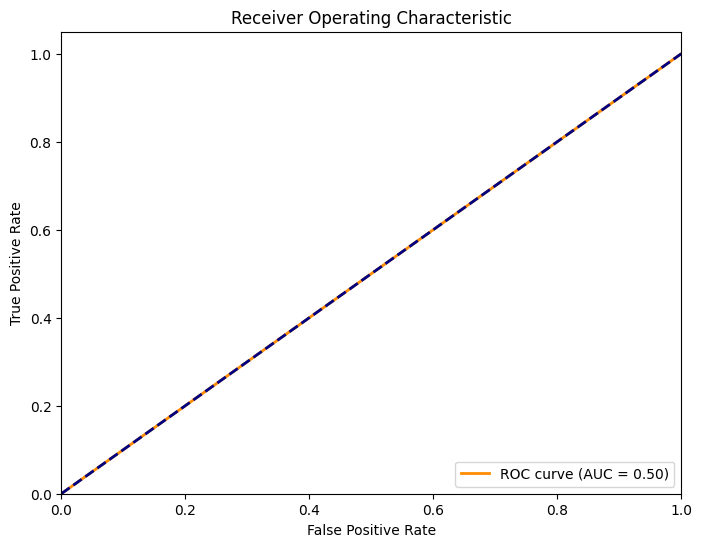

In [13]:
# Visualize ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Confusion Matrix')

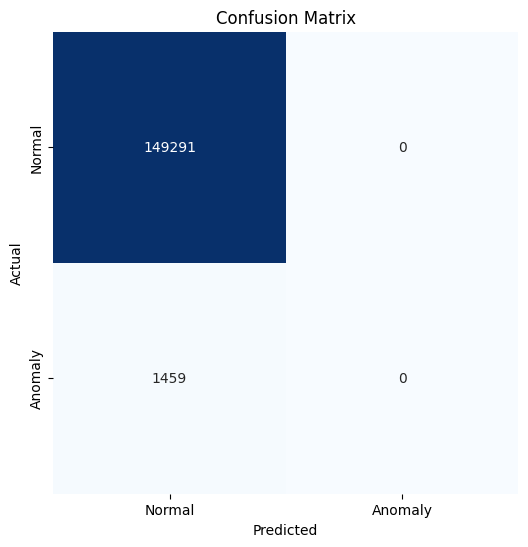

In [14]:
# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')



In [15]:
# Display Classification Report
print(report)

              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00    149291
     Anomaly       1.00      0.00      0.00      1459

    accuracy                           0.99    150750
   macro avg       1.00      0.50      0.50    150750
weighted avg       0.99      0.99      0.99    150750

